# Skew-T - ln P plot

Demonstrate how to construct dry adiabats and isotherms for
a thermodynamic diagram using the functions in
[makeSkew.py](https://github.com/phaustin/A405/blob/master/a405skewT/makeSkew.py)

In [1]:
import numpy as np
import pandas as pd
import h5py
from pprint import pformat
from matplotlib import pyplot as plt
from a405thermo.constants import constants as c
from scipy import optimize

### setting labels and ticks

The next box shows how to set up a plot of a 5 degree isotherm in
unskewed coordinates.   Not that I invert the yaxis so pressure increases
downwards, and I make y a log scale and draw a horizontal grid.

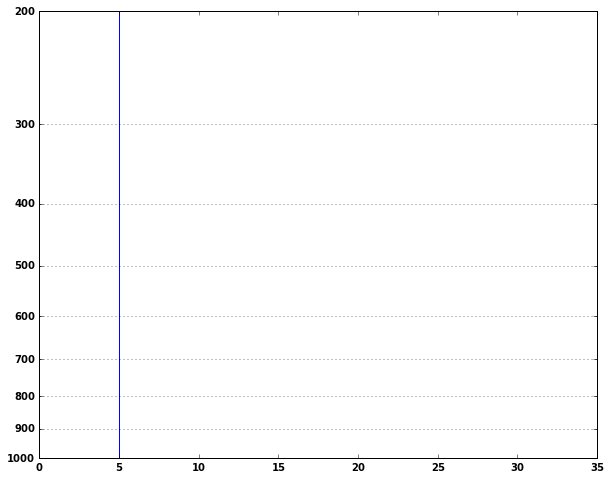

In [2]:
%matplotlib inline
press=np.linspace(200,1000,30)
temps=np.ones_like(press)*5
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(temps,press)
ax.set(xlim=[0,35])
ax.invert_yaxis()
ax.set_yscale('log')
locs = np.array(range(100, 1100, 100))
labels = locs
ax.set_yticks(locs)
ax.set_yticklabels(labels) # hand label the pressures
ax.set_ybound((200, 1000))
plt.setp(ax.get_xticklabels(), weight='bold')
plt.setp(ax.get_yticklabels(), weight='bold')
ax.yaxis.grid(True)


### Skewed temperature coordinates

If you try plotting your soundings on the conventional plot above, you'll see
that the height-temperature dependence makes it difficult to see the temperature
and dewpoint together.  The traditional approach is to slant the temperature
line by a constant slope (note that this is different from rotating the line,
because the y axis doesn't change)

In [3]:
def convertSkewToTemp(xcoord, press, skew):
    """
    convertSkewToTemp(xcoord, press, skew)

    Determines temperature from knowledge of a plotting coordinate
    system and corresponding plot skew.
    
    Parameters
    - - - - - -
    xcoord : int
        X coordinate in temperature plotting coordinates.
    press : float
        Pressure (hPa).
    skew : int
        Skew of a given coordinate system.

    Returns
    - - - -
    Temp : float
        Converted temperature in degC.

    Examples
    - - - - -
    >>> convertSkewToTemp(300, 8.e4, 30)
    638.6934574096806
    
    """
    Temp = xcoord  + skew * np.log(press);
    return Temp

def convertTempToSkew(Temp, press, skew):
    """
    convertTempToSkew(Temp, press, skew)

    Determines the transformed temperature in plotting coordinates.
    
    Parameters
    - - - - - -
    Temp : float
        Temperature (degC)
    press : float
        Pressure (hPa).
    skew : int
        Designated skew factor of temperature.

    Returns
    - - - -
    tempOut : float
        Converted temperature (degC).

    Examples
    - - - - -
    >>> convertTempToSkew(30., 8.e4, 30)
    -308.69345740968055
    
    """
    
    tempOut = Temp - skew * np.log(press);
    return tempOut


### Determining the skew

Getting a isotherm with a 45 degree slope in these coordinates is tricky, because it depends on
the shape of the plot and the exact range values chosen for the temperature and pressure axis.
Calculating the slope that will give a 45 degree angle isn't particularly hard (try it), but
it's easier to just try some different skew values, and then save the result so you can put
your data up in the same coordinates.  For square plots with typical sounding ranges setting
skew = 30 Kelvin  is about right

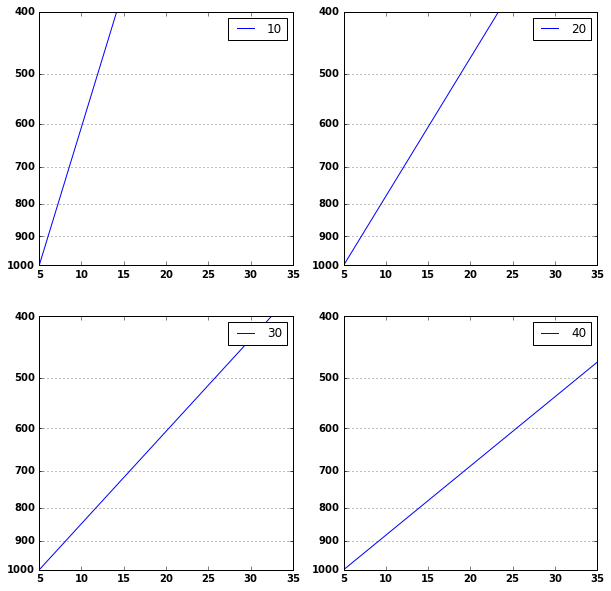

In [4]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
axes=axes.ravel()  #axes comes back as a 2x2 array, flatten it
press=np.linspace(200,1000,30)
the_temp=5.
linelist=[]
skew_vals=[10,20,30, 40]
for ax,skew in zip(axes,skew_vals):
    xcoord=convertTempToSkew(the_temp,press,skew)
    ax.plot(xcoord,press,label=skew)
    ax.invert_yaxis()
    ax.set_yscale('log')
    locs = np.array(range(100, 1100, 100))
    labels = locs
    ax.set_yticks(locs)
    ax.set_yticklabels(labels) # Conventionally labels semilog graph.
    ax.set_ybound((400, 1000))
    plt.setp(ax.get_xticklabels(), weight='bold')
    plt.setp(ax.get_yticklabels(), weight='bold')
    ax.yaxis.grid(True)
    out=ax.legend()
    TempTickLabels = range(-15, 40, 5)
    TempTickCoords = TempTickLabels
    skewTickCoords = convertTempToSkew(TempTickCoords, 1.e3, skew)
    ax.set_xticks(skewTickCoords)
    out=ax.set_xticklabels(TempTickLabels)
    skewLimits = convertTempToSkew([5, 35], 1.e3, skew)
    out=ax.set(xlim=skewLimits)

In [5]:
from a405skewT.makeSkew import makeSkewDry
import a405skewT.makeSkew
from importlib import reload
reload(a405skewT.makeSkew)

<module 'a405skewT.makeSkew' from '/Users/berringtonaca/repos/A405/a405skewT/makeSkew.py'>

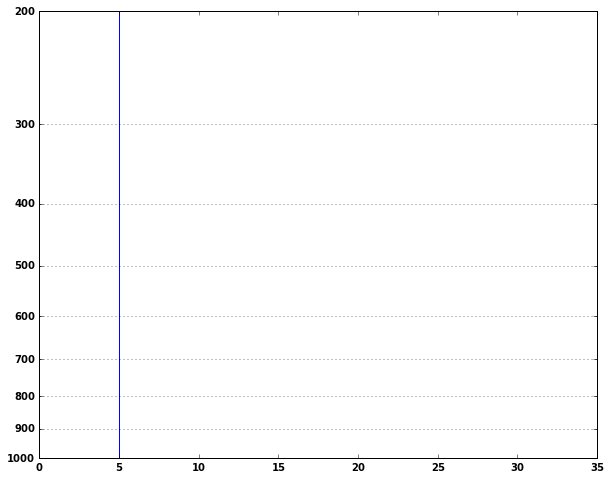

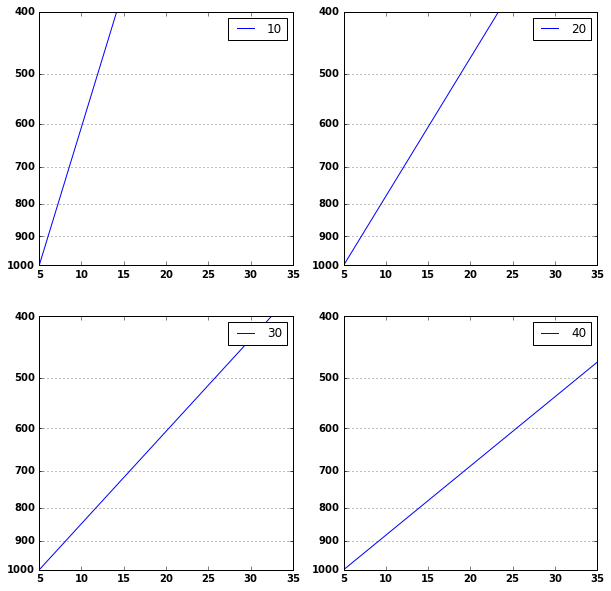

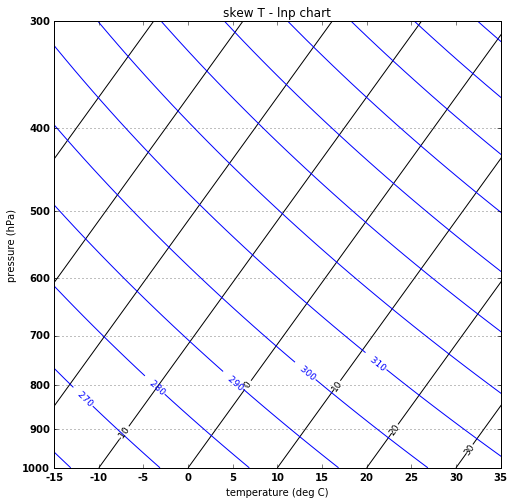

In [6]:
%config InlineBackend.close_figures=True
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)

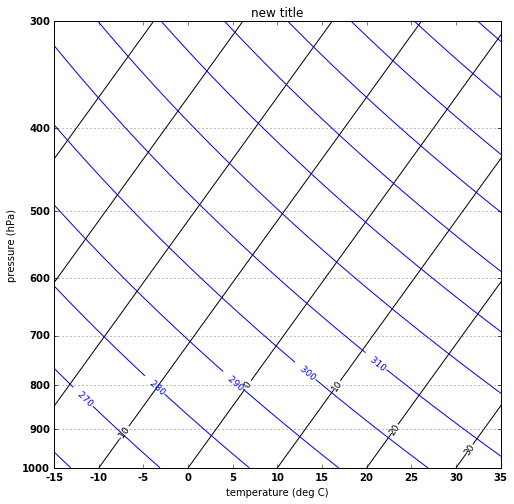

In [7]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)
ax.set(title='new title')
#display(fig)

In [8]:
filename='OUN.h5';
print('reading file: %s\n' %filename)

attributes={}
with h5py.File(filename,'r') as f:
    keys=f.attrs.keys()
    for key in keys:
        try:
            attributes[key]=f.attrs[key]
        except IOError:
            print('empty key: ',key)
print('\nread in these attributes: \n\n',pformat(attributes))

separator= '\n' + '+'*30 + '\n'
sounding_dict={}
with pd.HDFStore(filename,'r') as store:
    times=store.keys()
    for the_time in times:
        sounding_dict[the_time]=store[the_time]
sounding=sounding_dict[times[3]]
print('{0:}sounding times:{1:}{0:} '.format(separator,times))
print('{0:}columns: {1:}{0:} '.format(separator,pformat(sounding.columns)))
title_string=attributes['header']
index=title_string.find(' Observations at')
location=title_string[:index]
title='{} at {}'.format(location,times[0][2:])
print('title: :',title)
units=attributes['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns):
    units_dict[var]=units[count]
print('variables with units: \n',pformat(units_dict))

reading file: OUN.h5

empty key:  TITLE
empty key:  CLASS
empty key:  VERSION
empty key:  PYTABLES_FORMAT_VERSION

read in these attributes: 

 {'elevation': 3.0,
 'header': '72357 OUN Norman Observations at 00Z 01 May 2013',
 'history': 'written by test_requests.py',
 'latitude': 35.18,
 'longitude': -97.439999999999998,
 'query': 'http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=5&FROM=0100&TO=3112&STNM=72357',
 'site_id': '72357',
 'timestamp': '2016-01-19 23:16:57 UTC',
 'units': 'hPa;m;C;C;%;g/kg;deg;knot;K;K;K'}

++++++++++++++++++++++++++++++
sounding times:['/Y2013_May_01_00Z', '/Y2013_May_01_12Z', '/Y2013_May_02_00Z', '/Y2013_May_02_12Z', '/Y2013_May_03_00Z', '/Y2013_May_03_12Z', '/Y2013_May_04_00Z', '/Y2013_May_04_12Z', '/Y2013_May_05_00Z', '/Y2013_May_05_12Z', '/Y2013_May_06_00Z', '/Y2013_May_06_12Z', '/Y2013_May_07_00Z', '/Y2013_May_07_12Z', '/Y2013_May_08_00Z', '/Y2013_May_08_12Z', '/Y2013_May_09_00Z', '/Y2013_May_09_12Z', '/Y2013_May

[(1000, 400)]

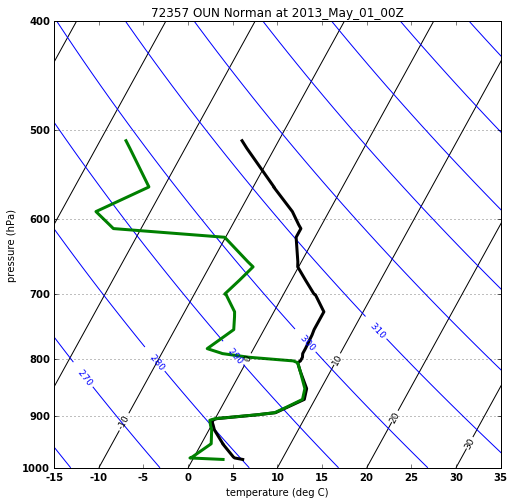

In [9]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)
triplets=zip(sounding['temp'],sounding['dwpt'],sounding['pres'])
xcoord_T=[]
xcoord_Td=[]
for a_temp,a_dew,a_pres in triplets:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))
ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')
fig.canvas.draw()

#
#  make the last two lines added to the plot (temp and dewpoint)
#  thicker
#
[line.set(linewidth=3) for line in ax.lines[-2:]]
ax.set(title=title)
ax.set(ylim=[1000,400])
#display(fig)

In [10]:
#ax.set(ylim=[1000,700])
#display(fig)

### For Wednesday 9am

Check in a notebook that puts your sounding on the tephigram and draws a line of constant saturation mixing ratio 
$r_s$ = 10 g/kg between 1000 and  400 hPa.  

Hint -- you want to rootfind the temperature that satisfies $r_s = \frac{e_s(T)}{p - e_s(T)} = 0.01\ g/kg$
for a range of pressures then convert the temperatures to skew coordinates.

In [11]:
from a405thermo import rootfinder as rf
def rootfind_es(es_guess, pressure, rs):
    '''root function for rs
    inputs: es_guess (Pa), pressure (Pa), rs (kg kg^-1)
    outputs: difference between rs_guess and rs'''
    
    epsilon = 0.622
    return ((es_guess*epsilon)/(pressure-es_guess))-rs

def rootfind_temp(temp_guess,es):
    '''root function for temperature
    inputs: temp_guess (K), es (Pa)
    outputs: difference between'''
    
    R_v = 461.5 # J kg^-1 K^-1
    T_0 = 273.15 # K
    C_pv = 1870 # J kg^-1 K^-1
    l_v0 = 2.501e6 # J kg^-1
    e_s0 = 6.11e2 # Pa
    Tp = 273.16 # K
    C_l = 4187 # J kg^-1 K^-1
    
    leftside = -R_v*np.log(es/e_s0)
    
    return (leftside - ((((C_pv-C_l)*(temp_guess-T_0)+l_v0)/temp_guess)+(C_l*np.log(temp_guess/Tp))-
                          (C_pv*np.log(temp_guess/Tp))-(l_v0/Tp)))

def calc_temp(pressure,rs):
    '''calculates rs for pressure
    inputs: pressure (Pa), rs (kg/kg)
    outputs: temperature (K)'''
    
    e_s = optimize.zeros.brentq(rootfind_es,0,pressure,args=(pressure,rs))
    temp = optimize.zeros.brentq(rootfind_temp,1,500,args=(e_s))
    return temp


In [12]:
pressarray = np.arange(1000,390,-10)*100 # for Pa
r_s = 0.01
thetemps=[]
for each_pressure in pressarray:
    thetemps.append(calc_temp(each_pressure, r_s))
    
    
thetemps = np.array(thetemps)-273.15
thepress = pressarray/100

[(1000, 400)]

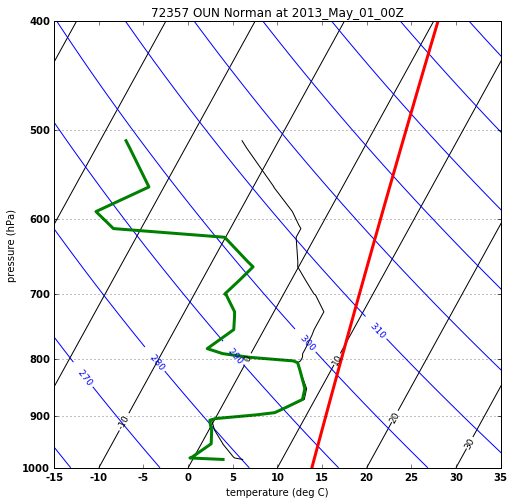

In [13]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)
triplets=zip(sounding['temp'],sounding['dwpt'],sounding['pres'])
newtuple=zip(thetemps,thepress)
xcoord_T=[]
xcoord_Td=[]
xcoord_newtemps=[]
for a_temp,a_dew,a_pres in triplets:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))
    
for new_temp,new_press in newtuple:
    xcoord_newtemps.append(convertTempToSkew(new_temp,new_press, skew))
    
ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')
ax.plot(xcoord_newtemps,thepress, color='r',label='isohume')
fig.canvas.draw()

#
#  make the last two lines added to the plot (temp and dewpoint)
#  thicker
#
[line.set(linewidth=3) for line in ax.lines[-2:]]
ax.set(title=title)
ax.set(ylim=[1000,400])

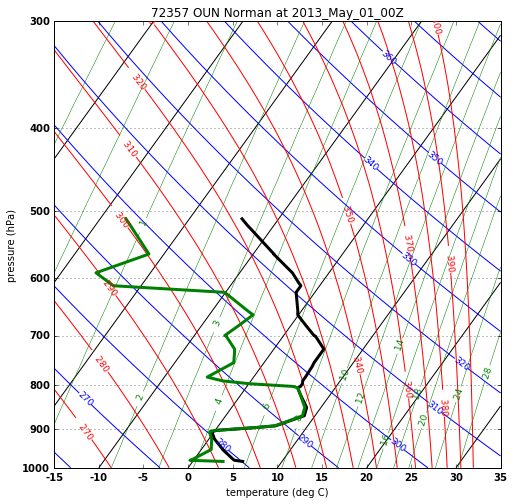

In [14]:
%matplotlib inline
import a405skewT.makeSkewII
reload(a405skewT.makeSkewII)
from a405skewT.makeSkewII import makeSkewWet,find_corners
plt.close('all')
fig,ax =plt.subplots(1,1,figsize=(8,8))
corners=[-15,35]
ax,skew = makeSkewWet(ax,corners=corners,skew=skew)
ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')
[line.set(linewidth=3) for line in ax.lines[-2:]]
out=ax.set(title=title)

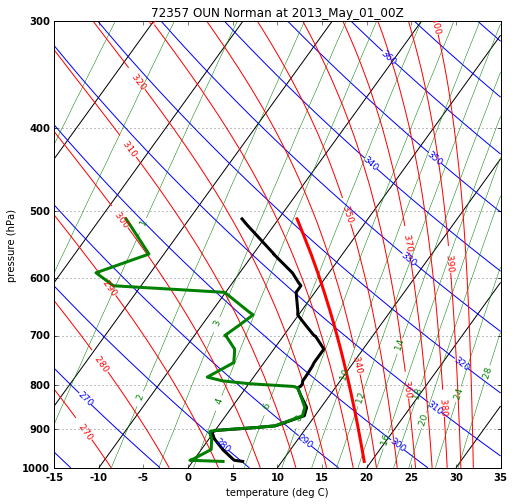

In [15]:
from a405thermo.thermlib import find_Tmoist
thetae=335.
temps= np.array([find_Tmoist(thetae,press*100.) for press in sounding['pres']])
temps = temps - c.Tc
xcoord_thetae=[]
for a_temp,a_press in zip(temps,sounding['pres']):
    out=convertTempToSkew(a_temp,a_press,skew)
    xcoord_thetae.append(out)
ax.plot(xcoord_thetae,sounding['pres'],color='r',label='rsat',linewidth=3.)
display(fig)

In [24]:
# For Friday, Feb 5th
from a405thermo.thermlib import find_lcl,find_thetaes,find_rsat,find_rvrl

lcl = find_lcl(sounding['dwpt'][0]+273.15,sounding['temp'][0]+273.15,sounding['pres'][0]*100)
thetaes_lcl = find_thetaes(lcl[0],lcl[1])
moisttemps= np.array([find_Tmoist(thetaes_lcl,press*100.) for press in sounding['pres']])

the_rt = find_rsat(sounding['dwpt'][0]+273.15,sounding['pres'][0]*100)

indexpressabove = np.where(sounding['pres']*100<lcl[1])
pressabove = (sounding['pres'][indexpressabove[0]])
tempabove = (sounding['temp'][indexpressabove[0]])+273.15

rvrls = []
for each_ind in indexpressabove[0]:
    rvrls.append(find_rvrl(tempabove[each_ind],the_rt,pressabove[each_ind]*100))
    
rvrlsarray = np.array(rvrls)

tempabovearray = np.array(tempabove)
r_vs = rvrlsarray[:,0]
r_ls = rvrlsarray[:,1]

def virtualtemp(temp,r_v,r_l):
    '''calculates virtual temperature
    inputs: temperature (K), r_v, r_l
    outputs: virtual temperature (K)'''
    
    
    virtualt = temp*(1+0.61*r_v-r_l)
    return virtualt

In [40]:
virtualt_env = []
for i in range(0, 32):
    virtualt_env.append(virtualtemp(tempabovearray[i],r_vs[i],r_ls[i]))
    
virtualt_moist = []
for i in range(0, 32):
    virtualt_moist.append(virtualtemp(moisttemps[i],r_vs[i],r_ls[i]))

diff_virtualt = np.array(virtualt_moist)-np.array(virtualt_env)
grav = 9.8 # m/s^2

cape_integrand = grav*(diff_virtualt/np.array(virtualt_env))

print(cape_integrand)

[ 0.1414  0.1507  0.1654  0.1005 -0.0498 -0.1684 -0.2185 -0.2842 -0.2764
 -0.2287 -0.2091 -0.236  -0.2642 -0.297  -0.3623 -0.394  -0.3975 -0.4081
 -0.4222 -0.4243 -0.3736 -0.4203 -0.38   -0.3729 -0.3829 -0.3946 -0.3975
 -0.4383 -0.4434 -0.3388 -0.4473 -0.2928]
